In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
import matplotlib.pyplot as plt

In [98]:
#load the dataset
data = pd.read_csv('../data/whole_dataset.csv')
data_description = pd.read_csv('../data/data_description.csv', encoding='iso-8859-1')
feature_name = data_description['Feature (nl)']
relative_importance = data_description['Relative importance']

# top 30 important features
relevant_features = data_description.nlargest(30, 'Relative importance')
# get features other than top 10 important features in train_data
features_to_delete = set(data_description['Feature (nl)']) - set(relevant_features['Feature (nl)'])

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked', 'Ja', 'Nee'], axis=1)

# find the feature names whose relative importance is not 0
X = X.astype(np.float32)
X = X.drop(features_to_delete, axis=1)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


# Select data based on variance (not the final version yet, for now just for testing)
# low_variance_filter = VarianceThreshold()

# Select data based on Lasso regression
# selector = SelectFromModel(Lasso(alpha=0.008))

# normalize the dataset
scaler = StandardScaler()

# Define a gradient boosting classifier
classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, subsample=0.9, random_state=0)

# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
pipeline = Pipeline(steps=[
    # ('low_variance_filter', low_variance_filter),
    # ('feature_selection', selector), 
    ('scaling', scaler), 
    ('classification', classifier)
    ])


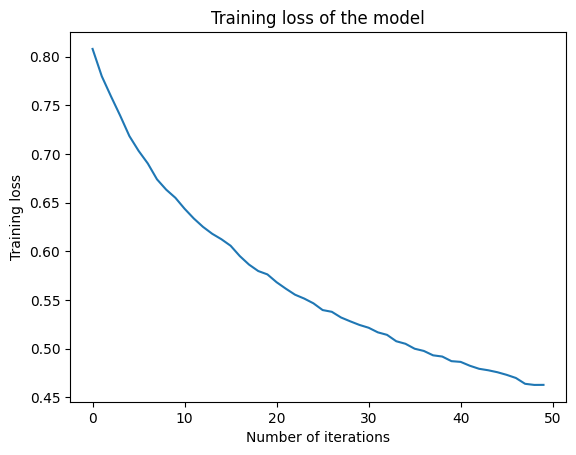

Accuracy of the original model:  0.9005274725274726


In [99]:
# X_step1 = pipeline.named_steps['low_variance_filter'].fit_transform(X_train)
# X_step2 = pipeline.named_steps['feature_selection'].fit_transform(X_step1, y_train)
# X_step3 = pipeline.named_steps['scaling'].fit_transform(X_step2)
# classifier = pipeline.named_steps['classification']
# classifier.fit(X_step3, y_train)

# print(X_step3.shape)

pipeline.fit(X_train, y_train)

# plot the training process
plt.plot(pipeline.named_steps['classification'].train_score_)
plt.xlabel('Number of iterations')
plt.ylabel('Training loss')
plt.title('Training loss of the model')
plt.show()

# Let's evaluate the model
# X_test_step1 = pipeline.named_steps['low_variance_filter'].transform(X_test)
# X_test_step2 = pipeline.named_steps['feature_selection'].transform(X_test_step1)
# X_test_step3 = pipeline.named_steps['scaling'].transform(X_test_step2)

y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

In [100]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X_train.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9005274725274726


In [104]:
# Let's save the model
onnx.save(onnx_model, "../model/gboost.onnx")

# Let's load the model
new_session = rt.InferenceSession("../model/gboost.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9005274725274726
